In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [1]:
from plotting import draw_1d, create_df
from plotting import var_kw, process_kw, nllscan_kw
import oyaml as yaml
import pandas as pd
import numpy as np
import dftools
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import dftools
import scipy
mpl.use('pdf')
plt.style.use('cms')

In [2]:
def custom_cms_label(ax, label, lumi=35.9, energy=13):
    ax.text(
        0, 1, r'$\mathbf{CMS}\ \mathit{'+label+'}$',
        ha='left', va='bottom', transform=ax.transAxes,
    )
    ax.text(
        1, 1, r'${:.0f}\ \mathrm{{fb}}^{{-1}}$ ({:.0f} TeV)'.format(lumi, energy),
        ha='right', va='bottom', transform=ax.transAxes,
    )

[array([0.84605951, 1.16200583]), array([0.70652478, 1.32992889])]

[('0.15', '0.16'), ('0.29', '0.33')]

1_{0.15}^{+0.16} {}^{\circ}$
1_{0.29}^{+0.33} {}^{\circ}$
SM vs PS significance is $0^+ \mathrm{vs}\ 0^- =$\ 7.63$\sigma$


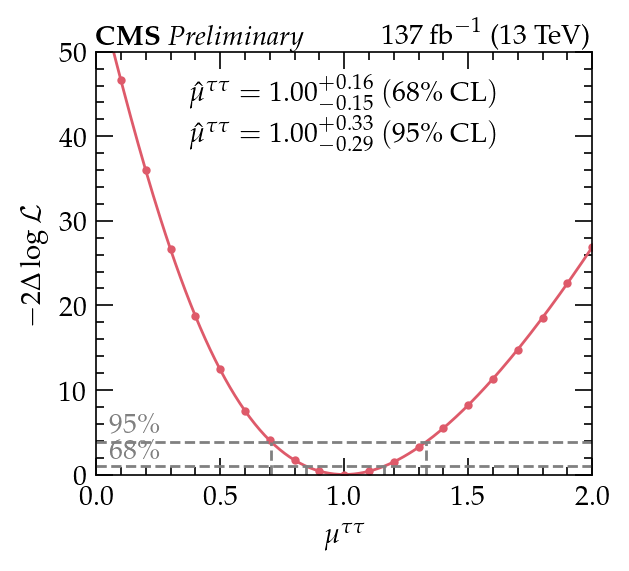

In [18]:
# combined scan
add_significance = False
#add = ""
add = "_mergeXbins"
parameter = "mutautau"
#parameter = "alpha"
boundaries = []
if parameter == "alpha":
    boundaries = [(-90,0), (0,90)]
elif parameter in ["muggH", "muV", "mutautau"]:
    boundaries = [(0,1), (1,2)]
else:
    boundaries = [(0,1), (1,2)]
with mpl.backends.backend_pdf.PdfPages(f"plots/{parameter}_cmb_19052020{add}.pdf", keep_empty=False,) as pdf:
    fig, ax = plt.subplots(
        figsize=(3.2, 2.8), dpi=200,
    )
    
    test = (
        "/vols/build/cms/akd116/newest/Combine/Decays/CMSSW_10_2_13/src/"
        "CombineHarvester/HTTSMCPDecays18/output/"
        f"19052020/cmb/125/higgsCombine.{parameter}.MultiDimFit.mH125.root"
        
        #"30042020_mergeXbins/cmb/125/higgsCombine.alpha.MultiDimFit.mH125.root"
        #"/vols/build/cms/dw515/CPdecay/CMSSW_10_2_13/src/"
        #"CombineHarvester/HTTSMCPDecays18/alpha_cmb.root"
        
        #"~/public_html/CP/202005_May/06_NewFitsPostFirstImpacts/"
        #f"higgsCombine.{parameter}.MultiDimFit.mH125.root"
    )
    f = uproot.open(test)["limit"]
    #display(f.keys())
    df = f.pandas.df([parameter,"deltaNLL","quantileExpected"],
        namedecode="utf-8")
    df = df.query("quantileExpected > -0.5")
    df = df.loc[~df.duplicated(),:]
    df = df.sort_values(by=parameter)
    
    scan_kw = dict(color=nllscan_kw["tt"][0][2])
    # either specify sigma or do using percent level
    #nsigs = [1,2]
    pc_level = [0.68, 0.95]
    #pc_level = []
    nsigs = []
    for pc in pc_level:
        nsigs.append(scipy.stats.norm.ppf((1+pc)/2))
    results = dftools.draw.nllscan(
        df[parameter], 2*df["deltaNLL"], ax=ax, nsigs=nsigs, 
        left_bracket=boundaries[0], right_bracket=boundaries[1],
        marker_kw=scan_kw, spline_kw=scan_kw,
    )
    custom_cms_label(ax, "Preliminary", lumi=137)
    if parameter == "alpha":
        ax.set_xticks([-90, -45, 0, 45, 90])
        ax.set_xlim(-90., 90)
        ax.set_ylim(0., None)
        
        #ax.text(-85, 1.01, r'$1\sigma$', ha='left', va='bottom', color='gray')
        #ax.text(-85, 4.01, r'$2\sigma$', ha='left', va='bottom', color='gray')
        ax.text(-85, 0.61, r'$68\%$', ha='left', va='bottom', color='gray')
        ax.text(-85, 3.41, r'$95\%$', ha='left', va='bottom', color='gray')
        #ax.text(-85, 1.01, r'$68\%$', ha='left', va='bottom', color='gray')
        #ax.text(-85, 4.01, r'$95\%$', ha='left', va='bottom', color='gray')
    else:
        ax.set_xlim(0, 2)
        ax.set_ylim(0., None)
        ax.text(0.05, 1.01, r'$68\%$', ha='left', va='bottom', color='gray')
        ax.text(0.05, 4.01, r'$95\%$', ha='left', va='bottom', color='gray')
        #ax.text(0.05, 3.41, r'$95\%$', ha='left', va='bottom', color='gray')
        #ax.text(0.55, 1.01, r'$68\%$', ha='left', va='bottom', color='gray')
        #ax.text(0.55, 4.01, r'$95\%$', ha='left', va='bottom', color='gray')
    
    bestfit = results.query("nsig == 0.")["xval"].values
    #result = np.abs(results.query("abs(nsig) == 1.")["xval"].values)
    #result_2s = np.abs(results.query("abs(nsig) == 2.")["xval"].values)
    result_values = []
    label_strings = []
    for nsig in nsigs:
        result_values.append(np.abs(results.query(f"abs(nsig) == {nsig}")["xval"].values))
    display(result_values)
    for result in result_values:
        unc_hi = result[1] - bestfit[0]
        unc_lo = bestfit[0] - result[0]
        hi_string = f"{unc_hi:.2f}"
        lo_string = f"{unc_lo:.2f}"
        string = (lo_string, hi_string)
        label_strings.append(string)
    display(label_strings)
    #if hi_string == lo_string:
    #    
    #    full_string = f"{bestfit[0]:.0f} \\pm {hi_string}\\ {{}}^{{\circ}}$"
    #else:
    full_strings = []
    for idx, string in enumerate(label_strings):
        #if abs(round(int(string[0]))) == abs(round(int(string[1]))):
        #    
        #    full_string = f"{bestfit[0]:.2f} \\pm {abs(int(string[0]))}\\ "
        #else:
        full_string = (f"{bestfit[0]:.2f}_{{-{string[0]}}}^{{+{string[1]}}}\\ ")
        full_strings.append(full_string)
        
        if parameter == "alpha":
            result_label = (
                r"$\hat{\phi}_{\tau\tau} = " + full_string + "{{}}^{{\circ}}"
            )
        elif parameter == "muggH":
            result_label = (
                r"$\hat{\mu}_{gg\mathrm{H}}^{\tau\tau} = " + full_string
            )
        elif parameter == "muV":
            result_label = (
                r"$\hat{\mu}_{\mathrm{V}}^{\tau\tau} = " + full_string
            )
        elif parameter == "mutautau":
            result_label = (
                r"$\hat{\mu}^{\tau\tau} = " + full_string
            )
            
        if idx == 0:
            ax.text(
                0.5, 0.85, 
                result_label + r"(68\%\ \mathrm{CL})$",
                ha='center', va='bottom',
                transform=ax.transAxes, 
            )
        elif idx == 1:
            ax.text(
                0.5, 0.75, 
                result_label + r"(95\%\ \mathrm{CL})$",
                ha='center', va='bottom',
                transform=ax.transAxes, 
            )
        
        print(f"{bestfit[0]:.0f}_{{{string[0]}}}^{{+{string[1]}}} {{}}^{{\circ}}$")
    
    # Add significance of SM vs PS discrimination
    significance = np.sqrt(
        scipy.stats.chi2.ppf(
            scipy.stats.chi2.cdf(
                [max(2*df["deltaNLL"])],
            1),
        1)
    )[0]
    sig_label = r"$0^+ \mathrm{vs}\ 0^- =$\ "+f"{significance:.2f}$\sigma$"
    print(f"SM vs PS significance is {sig_label}")
    if add_significance:
        ax.text(
            0.5, 0.65,
            sig_label,
            ha='center', va='bottom',
            transform=ax.transAxes,
        )
    ax.set_ylim(0, 50)

    if parameter == "alpha":
        ax.set_xlabel(r"$\phi_{\tau\tau} (\mathrm{degrees})$")
    elif parameter == "muggH":
        ax.set_xlabel(r"$\mu_{gg\mathrm{H}}^{\tau\tau}$")
    elif parameter == "muV":
        ax.set_xlabel(r"$\mu_{\mathrm{V}}^{\tau\tau}$")
        ax.set_ylim(0, 3.2)
    elif parameter == "mutautau":
        ax.set_xlabel(r"$\mu^{\tau\tau}$")
        #ax.set_ylim(0, 6.2)
        #ax.set_xlim(0.5, 1.5)
    #ax.set_ylim(0, 1.5)
    #ax.set_xlim(-2, 2)
    ax.set_ylabel(r"$-2\Delta\log\mathcal{L}$")
    pdf.savefig(fig, bbox_inches='tight')
pass

# Split by channel and category

SM vs PS significance for bin 0 is $0^+ \mathrm{vs}\ 0^- =$\ 1.43$\sigma$
SM vs PS significance for bin 3 is $0^+ \mathrm{vs}\ 0^- =$\ 1.11$\sigma$
SM vs PS significance for bin 4 is $0^+ \mathrm{vs}\ 0^- =$\ 0.69$\sigma$
SM vs PS significance for bin 5 is $0^+ \mathrm{vs}\ 0^- =$\ 0.49$\sigma$
SM vs PS significance for bin 6 is $0^+ \mathrm{vs}\ 0^- =$\ 0.23$\sigma$


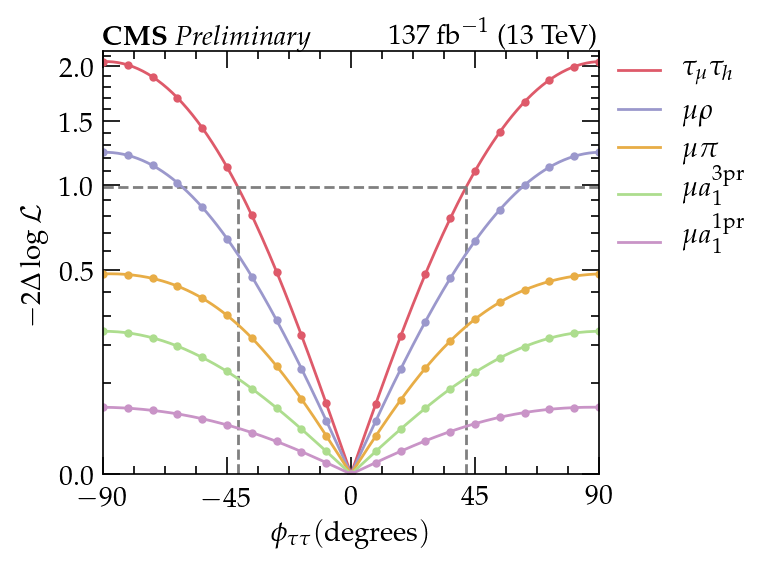

In [78]:
# split by channel and subcategories
channel = "mt"
with mpl.backends.backend_pdf.PdfPages(f"plots/alpha_{channel}_split_19052020_mergeXbins.pdf", keep_empty=False,) as pdf:
    fig, ax = plt.subplots(
        figsize=(3.2, 2.8), dpi=200,
    )
    
    if channel == "tt":
        ordered_list = [3,7,5,9,8,4,10,6,11]
    elif channel == "mt":
        ordered_list = list(np.arange(3,7,1))
    bins = [0] + ordered_list
    labels = []
    for (category, bin_) in zip(
        [f"htt_{channel}"] + [f"htt_{channel}_{x}_13TeV" for x in ordered_list], bins):
        scan_result = (
            #"/vols/build/cms/dw515/CPdecay/CMSSW_10_2_13/src/"
            #"CombineHarvester/HTTSMCPDecays18/output/"
            "/vols/build/cms/akd116/newest/Combine/Decays/CMSSW_10_2_13/src/"
            "CombineHarvester/HTTSMCPDecays18/output/"
            f"19052020/{category}/125/higgsCombine.alpha.MultiDimFit.mH125.root"
        )
        f = uproot.open(scan_result)["limit"]
        df = f.pandas.df(["alpha","deltaNLL","quantileExpected"],
            namedecode="utf-8")
        df = df.query("quantileExpected > -0.5")
        df = df.loc[~df.duplicated(),:]
        df = df.sort_values(by="alpha")
        
        xvalues = df["alpha"]
        yvalues = 2*df["deltaNLL"]
        
        if bin_ == 0:
            nsigmas = [scipy.stats.norm.ppf((1-(1-0.68)/2))]
        else:
            nsigmas = []
        
        scan_kw = dict(color=nllscan_kw[channel][bin_][2],)

        results = dftools.draw.nllscan(
            xvalues, yvalues, ax=ax, nsigs=nsigmas, 
            left_bracket=(-90,0), right_bracket=(0,90),
            marker_kw=scan_kw, spline_kw=scan_kw,
        )
        labels.append(nllscan_kw[channel][bin_][0])
        
        # print significance of each category
        significance = np.sqrt(
            scipy.stats.chi2.ppf(
                scipy.stats.chi2.cdf(
                    max(yvalues),
                1),
            1)
        )
        sig_label = r"$0^+ \mathrm{vs}\ 0^- =$\ "+f"{significance:.2f}$\sigma$"
        print(f"SM vs PS significance for bin {bin_} is {sig_label}")
    custom_cms_label(ax, "Preliminary", lumi=137)
    ax.set_xticks([-90, -45, 0, 45, 90])
    ax.set_xlim(-90., 90)
    ax.set_ylim(0., None)
    
    #ax.text(-85, 1.01, r'$68\%$', ha='left', va='bottom', color='gray')
    
    full_handles, full_labels = ax.get_legend_handles_labels()
    handles = [x for idx, x in enumerate(full_handles) if "Spline" in full_labels[idx]]
    ax.legend(handles, labels, bbox_to_anchor=(1, 1.03), labelspacing=0.3, borderpad=0.2)
    ax.set_xlabel(r"$\phi_{\tau\tau} (\mathrm{degrees})$")
    
    ax.set_yscale('function', functions=(lambda x: np.maximum(x, 0)**0.5, lambda x: x**2))
    ax.set_ylabel(r"$-2\Delta\log\mathcal{L}$")
    
    pdf.savefig(fig, bbox_inches='tight')
    pass

SM vs PS significance for year combined is $0^+ \mathrm{vs}\ 0^- =$\ 2.25$\sigma$
SM vs PS significance for year 2016 is $0^+ \mathrm{vs}\ 0^- =$\ 1.12$\sigma$
SM vs PS significance for year 2017 is $0^+ \mathrm{vs}\ 0^- =$\ 1.14$\sigma$
SM vs PS significance for year 2018 is $0^+ \mathrm{vs}\ 0^- =$\ 1.58$\sigma$


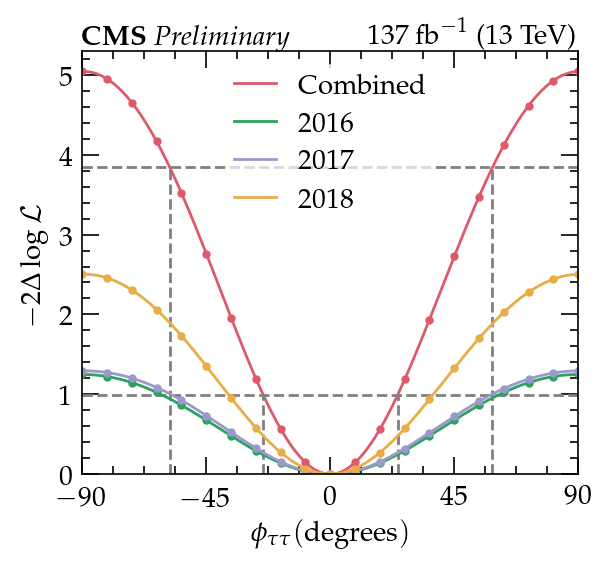

In [79]:
# split by years
channel = "years"
with mpl.backends.backend_pdf.PdfPages(f"plots/alpha_split_years_19052020_mergeXbins.pdf", keep_empty=False,) as pdf:
    fig, ax = plt.subplots(
        figsize=(3.2, 2.8), dpi=200,
    )
    
    labels = []
    significances = []
    for idx, category in enumerate(["cmb","htt_2016", "htt_2017", "htt_2018"]):
        scan_result = (
            #"/vols/build/cms/dw515/CPdecay/CMSSW_10_2_13/src/"
            #"CombineHarvester/HTTSMCPDecays18/output/"
            "/vols/build/cms/akd116/newest/Combine/Decays/CMSSW_10_2_13/src/"
            "CombineHarvester/HTTSMCPDecays18/output/"
            f"19052020/{category}/125/higgsCombine.alpha.MultiDimFit.mH125.root"
        )
        f = uproot.open(scan_result)["limit"]
        df = f.pandas.df(["alpha","deltaNLL","quantileExpected"],
            namedecode="utf-8")
        df = df.query("quantileExpected > -0.5")
        df = df.loc[~df.duplicated(),:]
        df = df.sort_values(by="alpha")
        
        xvalues = df["alpha"]
        yvalues = 2*df["deltaNLL"]
        
        if idx == 0:
            nsigmas = [scipy.stats.norm.ppf((1+0.68)/2),scipy.stats.norm.ppf((1+0.95)/2)]
        else:
            nsigmas = []
        
        scan_kw = dict(color=nllscan_kw[channel][idx][2],)

        results = dftools.draw.nllscan(
            xvalues, yvalues, ax=ax, nsigs=nsigmas, 
            left_bracket=(-90,0), right_bracket=(0,90),
            marker_kw=scan_kw, spline_kw=scan_kw,
        )
        labels.append(nllscan_kw[channel][idx][0])
        
        # print significance of each category
        significance = np.sqrt(
            scipy.stats.chi2.ppf(
                scipy.stats.chi2.cdf(
                    max(yvalues),
                1),
            1)
        )
        sig_label = r"$0^+ \mathrm{vs}\ 0^- =$\ "+f"{significance:.2f}$\sigma$"
        print(f"SM vs PS significance for year {nllscan_kw[channel][idx][1]} is {sig_label}")
        significances.append(sig_label)
    custom_cms_label(ax, "Preliminary", lumi=137)
    ax.set_xticks([-90, -45, 0, 45, 90])
    ax.set_xlim(-90., 90)
    ax.set_ylim(0., None)
    
    #ax.text(-85, 1.01, r'$68\%$', ha='left', va='bottom', color='gray')
    
    full_handles, full_labels = ax.get_legend_handles_labels()
    handles = [x for idx, x in enumerate(full_handles) if "Spline" in full_labels[idx]]
    #ax.legend(handles, labels, bbox_to_anchor=(1, 1.03), labelspacing=0.3, borderpad=0.2)
    ax.legend(handles, labels, loc=9, labelspacing=0.3, borderpad=0.2, framealpha=0.7)
    ax.set_xlabel(r"$\phi_{\tau\tau} (\mathrm{degrees})$")
    
    #ax.set_yscale('function', functions=(lambda x: np.maximum(x, 0)**0.5, lambda x: x**2))
    ax.set_ylabel(r"$-2\Delta\log\mathcal{L}$")
    
    pdf.savefig(fig, bbox_inches='tight')
    pass

# Scan versus another nuisance


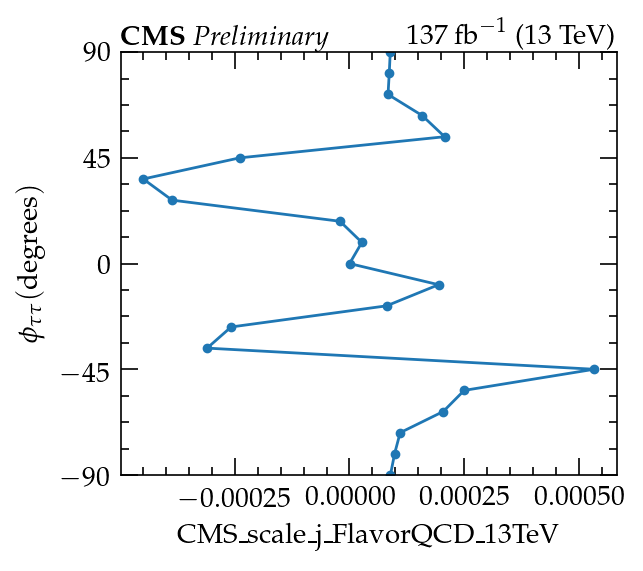

In [81]:
# combined scan
add_significance = False
#add = ""
parameter = "alpha"
parameter1 = "CMS_scale_j_FlavorQCD_13TeV"
#parameter1 = "CMS_res_j_13TeV_2018"
with mpl.backends.backend_pdf.PdfPages(f"plots/{parameter}_{parameter1}_cmb_19052020{add}.pdf", keep_empty=False,) as pdf:
    fig, ax = plt.subplots(
        figsize=(3.2, 2.8), dpi=200,
    )
    
    test = (
        "/vols/build/cms/akd116/newest/Combine/Decays/CMSSW_10_2_13/src/"
        "CombineHarvester/HTTSMCPDecays18/output/"
        f"19052020/cmb/125/higgsCombine.{parameter}.MultiDimFit.mH125.root"
    )
    f = uproot.open(test)["limit"]
    #display(f.keys())
    df = f.pandas.df([parameter,parameter1,"quantileExpected"],
        namedecode="utf-8")
    df = df.query("quantileExpected > -0.5")
    df = df.loc[~df.duplicated(),:]
    df = df.sort_values(by=parameter)
    
    ax.plot(df[parameter1], df[parameter], 'o-')
    
    custom_cms_label(ax, "Preliminary", lumi=137)
    ax.set_xlabel(parameter1.replace("_","\_"))
    ax.set_ylabel(r"$\phi_{\tau\tau} (\mathrm{degrees})$")
    ax.set_yticks([-90, -45, 0, 45, 90])
    ax.set_ylim(-90., 90)
    pdf.savefig(fig, bbox_inches='tight')
pass

# 2d scans of kappa's

,kappaH,kappaA,deltaNLL,quantileExpected
entry,,,,
1,-2.0,-2.000000,368.114899,0.000000e+00
3,-2.0,-1.909091,347.045715,0.000000e+00
2212,-2.0,-1.818182,326.884277,0.000000e+00
2434,-2.0,-1.727273,307.615753,0.000000e+00
2655,-2.0,-1.636364,289.288971,0.000000e+00
...,...,...,...,...
2202,2.0,-0.636364,149.634689,3.215437e-33
2204,2.0,-0.545455,143.037155,8.707158e-32
2206,2.0,-0.454545,137.499008,1.388257e-30


array([[368.1149 , 347.90756, 328.5983 , ..., 328.42453, 347.6937 ,
        367.84155],
       [347.04572, 326.79367, 307.42535, ..., 307.22925, 326.55698,
        346.69586],
       [326.88428, 306.56842, 287.1856 , ..., 287.03076, 306.28012,
        326.49615],
       ...,
       [326.4936 , 306.33728, 287.031  , ..., 287.18567, 306.56967,
        300.     ],
       [346.69586, 326.55698, 307.2338 , ..., 307.42532, 326.79367,
        300.     ],
       [367.84155, 347.6937 , 328.42493, ..., 328.5986 , 347.90756,
        300.     ]], dtype=float32)

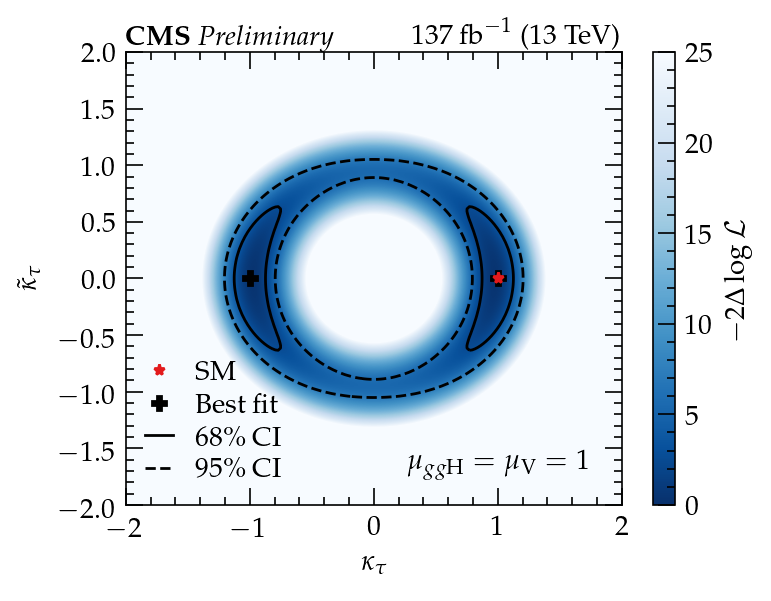

In [55]:
import scipy.ndimage
import numpy as np

with mpl.backends.backend_pdf.PdfPages(f"plots/scan-2d-kappa.pdf", keep_empty=False,) as pdf:
    fig, ax = plt.subplots(
        figsize=(4, 3), dpi=200,
    )
    test = (
        #"/vols/build/cms/akd116/newest/Combine/Decays/CMSSW_10_2_13/src/"
        #"CombineHarvester/HTTSMCPDecays18/output/"
        #f"19052020/cmb/125/higgsCombine.{parameter}.MultiDimFit.mH125.root"
        
        #"30042020_mergeXbins/cmb/125/higgsCombine.alpha.MultiDimFit.mH125.root"
        #"/vols/build/cms/dw515/CPdecay/CMSSW_10_2_13/src/"
        #"CombineHarvester/HTTSMCPDecays18/alpha_cmb.root"
        
        #"~/public_html/CP/202005_May/06_NewFitsPostFirstImpacts/"
        #f"higgsCombine.{parameter}.MultiDimFit.mH125.root"
        
        "/vols/build/cms/dw515/CPdecay/CMSSW_10_2_13/src/CombineHarvester/HTTSMCPDecays18/"
        "output/merge_sig/cmb/125/higgsCombine.kappas_v2.MultiDimFit.mH125.root"
    )
    parameter0 = "kappaH"
    parameter1 = "kappaA"
    f = uproot.open(test)["limit"]
    #display(f.keys())
    df = f.pandas.df([parameter0, parameter1, "deltaNLL","quantileExpected"],
        namedecode="utf-8")
    df = df.query("quantileExpected > -0.5 and deltaNLL < 1000 ")
    df = df.loc[~df.duplicated(),:]
    #df = df.fillna(0)
    df = df.sort_values(by=[parameter0, parameter1])
    custom_cms_label(ax, "Preliminary", lumi=137)
    
    xbins = df[parameter0].unique()
    ybins = df[parameter1].unique()
    df["deltaNLL"] = 2*df["deltaNLL"]
    display(df)
    z = df.set_index([parameter0, parameter1])["deltaNLL"].unstack().values.T
    # some nans...remove by setting to high value (high NLL)
    # this is only a temp. fix, hopefully fix to Physics model will remove these
    z[np.isnan(z)] = 300
    display(z)
    
    pos = ax.imshow(
        z, origin='lower', interpolation='bicubic',
        extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
        aspect='auto', cmap="Blues_r",
        vmin=0., vmax=25.,
    )
    cbar = fig.colorbar(pos, ax=ax)
    cbar.set_label(r'$-2\Delta\log \mathcal{L}$')
    
    X, Y = np.meshgrid(xbins, ybins)
    ax.contour(
        scipy.ndimage.zoom(X, 4),
        scipy.ndimage.zoom(Y, 4),
        scipy.ndimage.zoom(z, 4),
        levels=[scipy.stats.chi2.ppf(0.68, df=2)],
        colors=['black'],
    )
    ax.contour(
        scipy.ndimage.zoom(X, 4),
        scipy.ndimage.zoom(Y, 4),
        scipy.ndimage.zoom(z, 4),
        levels=[scipy.stats.chi2.ppf(0.95, df=2)],
        colors=['black'], linestyles='dashed',
    )
    bf = (
        df.loc[df["deltaNLL"]==df["deltaNLL"].min(), parameter0],
        df.loc[df["deltaNLL"]==df["deltaNLL"].min(), parameter1],
    )
    ax.plot(
        *bf, 'P', color='black',
        ms=5, label="Best fit",
    )
    ax.plot(
        1, 0, '*', color='#e31a1c',
        ms=4, label="SM",
    )
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[::-1] + [
        mpl.lines.Line2D([0], [0], color='black', lw=1),
        mpl.lines.Line2D([0], [0], color='black', lw=1, ls='--'),
    ]
    labels = labels[::-1] + [r'$68\%$ CI', r'$95\%$ CI']
    ax.legend(
        handles, labels,
        loc=3, labelspacing=0.1, borderpad=0.2,
        fancybox=True, edgecolor='#d9d9d9',
        framealpha=0., handlelength=1.,
    )
    ax.text(
        0.75, 0.05, r"$\mu_{gg\mathrm{H}} = \mu_{\mathrm{V}} = 1$",
        ha='center', va='bottom', transform=ax.transAxes,
    )

    
    ax.set_xlabel(r'$\kappa_{\tau}$')
    ax.set_ylabel(r'$\tilde{\kappa}_{\tau}$')
    #ax.set_ylim(-1.7, 1.7)
    #ax.set_xlim(-1.7, 1.7)
    pdf.savefig(fig, bbox_inches='tight')
    pass


# Some tests

In [23]:
from scipy.optimize import curve_fit
from scipy.stats import norm

[-90.  -82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5
   0.    7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5
  90. ]
-2.8836865 27.797688
Fit results: -2.8836865425109863,  27.797687530517578


(0.0, 0.023799999999999998)

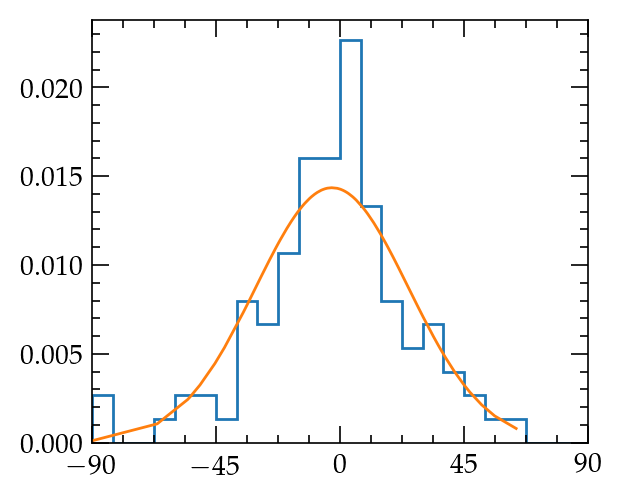

In [41]:
test = (
    "/vols/build/cms/akd116/newest/Combine/Decays/CMSSW_10_2_13/src/"
    "CombineHarvester/HTTSMCPDecays18/output/"
    "14042020/cmb/125/higgsCombine.alpha.MultiDimFit.mH125.123456.root"
)
f = uproot.open(test)["limit"]
df = f.pandas.df(["alpha","deltaNLL","quantileExpected"],
    namedecode="utf-8")
df = df.sort_values(by="alpha")

fig, ax = plt.subplots(
    figsize=(3.2, 2.8), dpi=200,
)
low_edges = np.linspace(-90, 90, num=25)
print(low_edges)
ax.hist(df["alpha"], bins=low_edges, histtype='step', density=True)

mean, std = norm.fit(df["alpha"])
print(mean, std)
p = norm.pdf(df["alpha"], mean, std)
plt.plot(df["alpha"], p, linewidth=1)
print(f"Fit results: {mean},  {std}")

ax.set_xticks([-90, -45, 0, 45, 90])
ax.set_xlim(-90., 90)
ax.set_ylim(0., None)